In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the training and test data from the URLs
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

# Load the datasets into pandas DataFrames without headers
train_data = pd.read_csv(train_url, sep='\t', header=None)
test_data = pd.read_csv(test_url, sep='\t', header=None)

# Assign column names: column 0 is the sentence, column 1 is the label
train_data.columns = ['sentence', 'label']
test_data.columns = ['sentence', 'label']

# Display first few rows to check the data
print("Training data:")
print(train_data.head())
print("\nTest data:")
print(test_data.head())

# Function to separate the sentence and label
def separate_label_and_sentence(data):
    sentences = data['sentence'].tolist()  # Directly take sentences
    labels = data['label'].tolist()  # Directly take labels
    return sentences, labels

# Apply the function to both train and test data
train_sentences, train_labels = separate_label_and_sentence(train_data)
test_sentences, test_labels = separate_label_and_sentence(test_data)

# Update the train_data and test_data with the new sentence and label columns
train_data['sentence'] = train_sentences
train_data['label'] = train_labels

test_data['sentence'] = test_sentences
test_data['label'] = test_labels

# Split the training data into training and validation sets (80% train, 20% validation)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

# Verify the split
print(f"Training data shape: {train_data.shape}")
print(f"Validation data shape: {val_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Example of the updated data
print("\nUpdated Training Data:")
print(train_data.head())


Training data:
                                            sentence  label
0  a stirring , funny and finally transporting re...      1
1  apparently reassembled from the cutting room f...      0
2  they presume their audience wo n't sit still f...      0
3  this is a visually stunning rumination on love...      1
4  jonathan parker 's bartleby should have been t...      1

Test data:
                                            sentence  label
0       no movement , no yuks , not much of anything      0
1  a gob of drivel so sickly sweet , even the eag...      0
2  gangs of new york is an unapologetic mess , wh...      0
3  we never really feel involved with the story ,...      0
4              this is one of polanski 's best films      1
Training data shape: (5536, 2)
Validation data shape: (1384, 2)
Test data shape: (1821, 2)

Updated Training Data:
                                               sentence  label
4457  graphic sex may be what 's attracting audience...      1
2471        

In [2]:
import torch
import torch.nn as nn

# Define the MLP model
class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(MLPModel, self).__init__()
        layers = []
        in_features = input_size
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(0.3))
            in_features = hidden_size
        layers.append(nn.Linear(in_features, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Initialize the model
input_size = 10000  # Example input size
hidden_sizes = [512, 256, 128, 64]
output_size = 2  # Two labels
model = MLPModel(input_size, hidden_sizes, output_size)

# Print the model summary
print(model)

# Function to count trainable parameters
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Count and print the number of trainable parameters
num_params = count_trainable_parameters(model)
print(f"Number of trainable parameters: {num_params}")

MLPModel(
  (model): Sequential(
    (0): Linear(in_features=10000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=128, out_features=64, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=64, out_features=2, bias=True)
  )
)
Number of trainable parameters: 5293122


Epoch 1/10 - Val Loss: 9.6195, Val Accuracy: 0.7991
✔️ Best model saved!
Epoch 2/10 - Val Loss: 13.4193, Val Accuracy: 0.7522
Epoch 3/10 - Val Loss: 9.6904, Val Accuracy: 0.7977
Epoch 4/10 - Val Loss: 5.8795, Val Accuracy: 0.7912
Epoch 5/10 - Val Loss: 5.0801, Val Accuracy: 0.7847
Epoch 6/10 - Val Loss: 3.1887, Val Accuracy: 0.7868
Epoch 7/10 - Val Loss: 2.8080, Val Accuracy: 0.7955
Epoch 8/10 - Val Loss: 2.9368, Val Accuracy: 0.7897
Epoch 9/10 - Val Loss: 2.4849, Val Accuracy: 0.7905
Epoch 10/10 - Val Loss: 2.9307, Val Accuracy: 0.7803


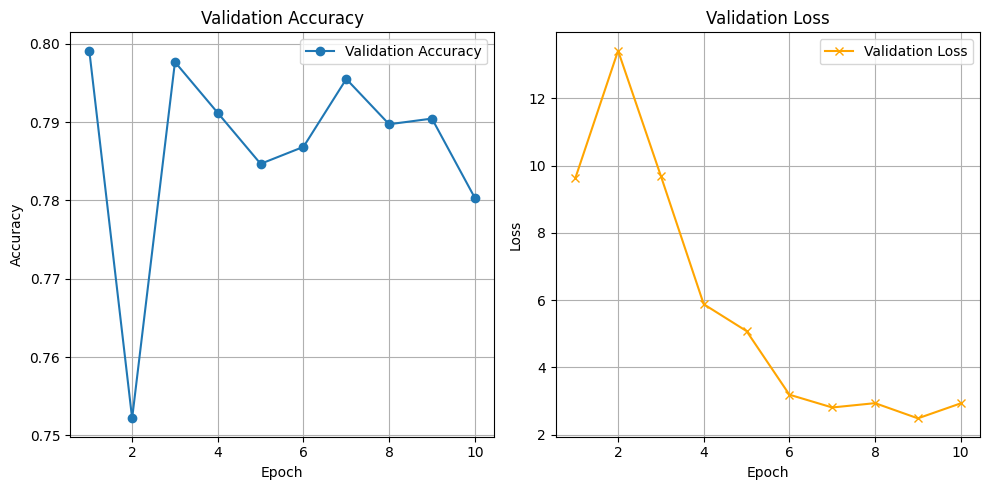

In [9]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert sentences to vectors using CountVectorizer
vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_data['sentence'])

# Transform all datasets
X_train = vectorizer.transform(train_data['sentence']).toarray()
y_train = train_data['label'].values

X_val = vectorizer.transform(val_data['sentence']).toarray()
y_val = val_data['label'].values

X_test = vectorizer.transform(test_data['sentence']).toarray()
y_test = test_data['label'].values

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoaders
batch_size = 64
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=batch_size)

# Step 2: Training Loop
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Store training stats
val_accuracies = []
val_losses = []
best_accuracy = 0.0

for epoch in range(10):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

    # Validation after each epoch
    model.eval()
    all_preds, all_labels = [], []
    total_val_loss = 0.0

    with torch.no_grad():
        for val_X, val_y in val_loader:
            val_X, val_y = val_X.to(device), val_y.to(device)
            outputs = model(val_X)
            loss = criterion(outputs, val_y)
            total_val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_y.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/10 - Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        torch.save(model.state_dict(), "checkpoint.pt")
        print("✔️ Best model saved!")

# Step 3: Plot Validation Accuracy and Loss
epochs = np.arange(1, 11)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, val_accuracies, marker='o', label='Validation Accuracy')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, val_losses, marker='x', color='orange', label='Validation Loss')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [37]:
import time
import os

# Load the best saved model
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
model.to(device)

# Measure inference time and accuracy
all_preds, all_labels = [], []
start_time = time.time()

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

end_time = time.time()
test_accuracy = accuracy_score(all_labels, all_preds)
inference_time_ms = (end_time - start_time) * 1000  # in milliseconds

# Get the storage size of the model
model_size_mb = os.path.getsize("checkpoint.pt") / 1e6  # in MB

# Print final evaluation
print("\n Original Model")
print(f"Accuracy         : {test_accuracy:.4f}")
print(f"Inference Time   : {inference_time_ms:.2f} ms (entire test set)")
print(f"Model Size       : {model_size_mb:.2f} MB")



 Original Model
Accuracy         : 0.7809
Inference Time   : 61.19 ms (entire test set)
Model Size       : 21.18 MB


In [38]:
import torch
import torch.nn as nn
from torch.quantization import quantize_dynamic
import time
import os
from sklearn.metrics import accuracy_score


# Load your trained full-precision model
model_fp32 = MLPModel(input_size, hidden_sizes, output_size)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

# === Apply dynamic quantization ===
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model_fp32,              # original model
    {nn.Linear},             # layers to quantize
    dtype=torch.qint8        # use int8 quantization
)

# Save the quantized model weights
torch.save(model_dynamic_quantized.state_dict(), "model_dynamic_quantized.pt")

# === Evaluate quantized model ===
def evaluate_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    start = time.time()
    with torch.no_grad():
        for X, y in data_loader:
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    end = time.time()
    acc = accuracy_score(all_labels, all_preds)
    inference_time = (end - start) * 1000  # in milliseconds
    return acc, inference_time

# Evaluate on your test set (ensure test_loader is defined)
acc_dyn, time_dyn = evaluate_model(model_dynamic_quantized, test_loader)

# === Report results ===
size_dyn = os.path.getsize("model_dynamic_quantized.pt") / 1e6  # in MB
print(f"[Dynamic Quantization - INT8]")
print(f"Accuracy: {acc_dyn:.4f}")
print(f"Inference Time: {time_dyn:.2f} ms")
print(f"Model Size: {size_dyn:.2f} MB")


[Dynamic Quantization - INT8]
Accuracy: 0.7820
Inference Time: 155.07 ms
Model Size: 5.30 MB


In [42]:
import torch
import torch.nn as nn
import time
import os
from sklearn.metrics import accuracy_score



# Load trained full-precision model
model_fp32 = MLPModel(input_size, hidden_sizes, output_size)
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

# === Convert model to half-precision ===
model_half = model_fp32.half()

# === Evaluate model ===
def evaluate_half_model(model, data_loader):
    model.eval()
    all_preds, all_labels = [], []
    start = time.time()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.half()  # Convert input to half precision
            outputs = model(X)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())
    end = time.time()
    acc = accuracy_score(all_labels, all_preds)
    inference_time = (end - start) * 1000  # in ms
    return acc, inference_time

# Evaluate on test data (make sure test_loader is defined)
acc_half, time_half = evaluate_half_model(model_half, test_loader)

# Save the half precision model
torch.save(model_half.state_dict(), "model_half_precision.pt")

# Measure model size
size_half = os.path.getsize("model_half_precision.pt") / 1e6  # in MB

# === Print Results ===
print(f"[Half Precision]")
print(f"Accuracy: {acc_half:.4f}")
print(f"Inference Time: {time_half:.2f} ms")
print(f"Model Size: {size_half:.2f} MB")


[Half Precision]
Accuracy: 0.7809
Inference Time: 1638.32 ms
Model Size: 10.59 MB


In [43]:
import pandas as pd

# Data for the models
data = {
    "Model": ["Original", "Half Precision", "Dynamic Quantization (INT8)"],
    "Accuracy (out of 100)": [78.09, 78.09, 78.20],
    "Inference Time (ms)": [61.19,1638.32, 155.07],
    "Model Size (MB)": [21.18, 10.59, 5.30]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display the table
print(df.to_string(index=False))


                      Model  Accuracy (out of 100)  Inference Time (ms)  Model Size (MB)
                   Original                  78.09                61.19            21.18
             Half Precision                  78.09              1638.32            10.59
Dynamic Quantization (INT8)                  78.20               155.07             5.30
